In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_cleaning_import import clean_create_vectors

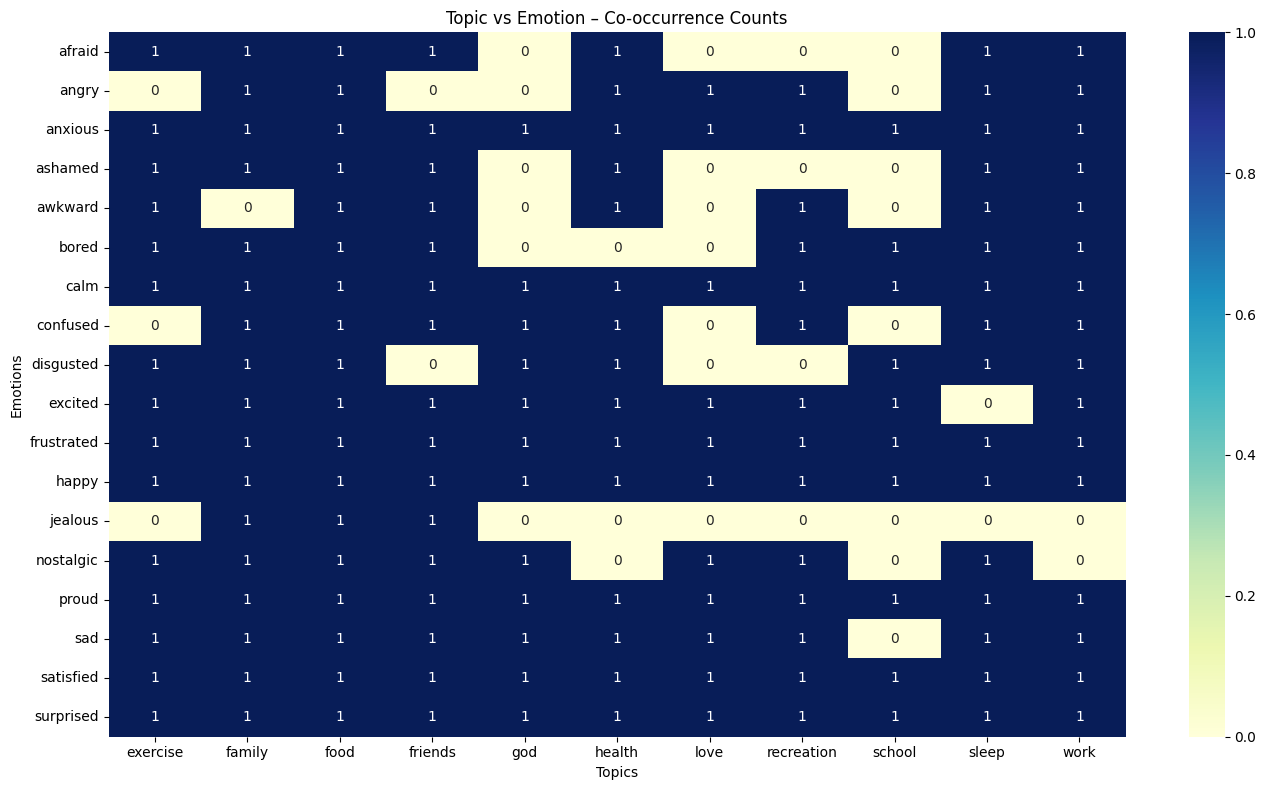

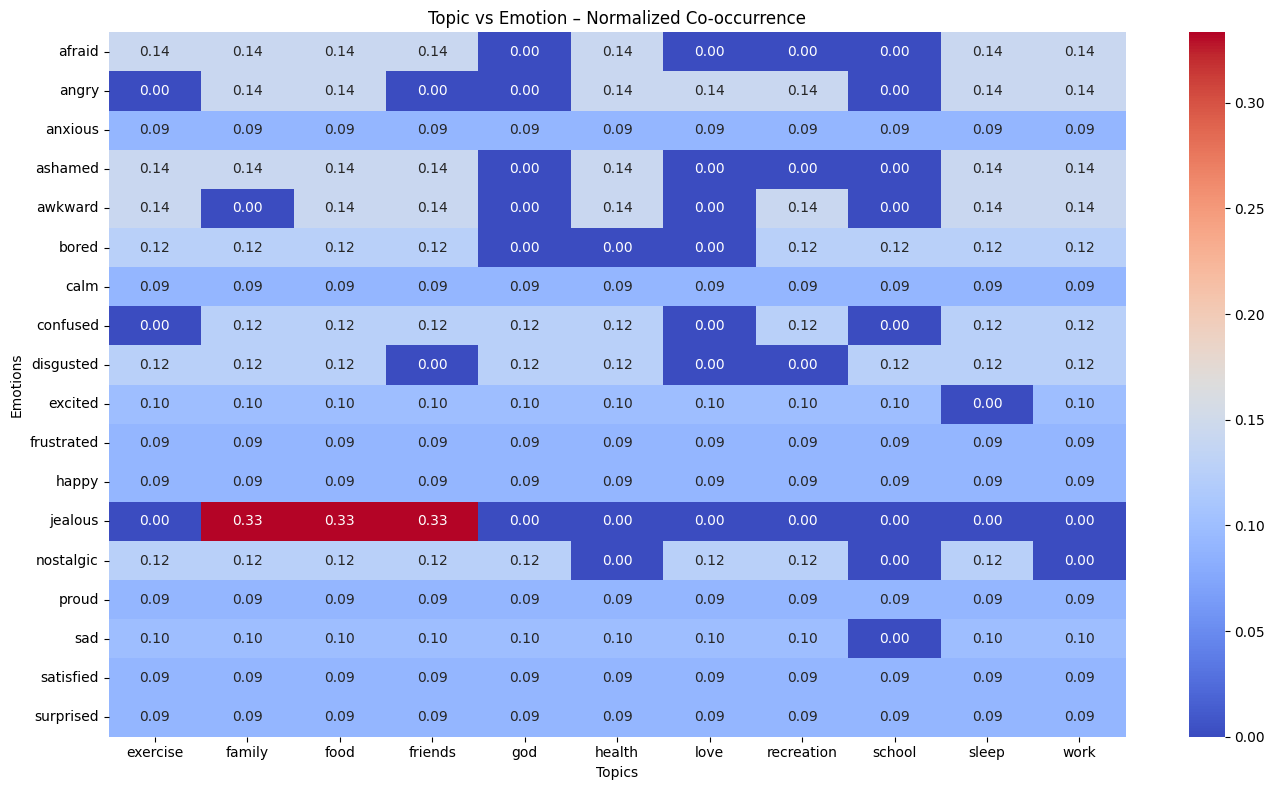

In [3]:
df = pd.read_csv("data.csv")
df = clean_create_vectors(df)

emotion_cols = ["afraid", "angry", "anxious", "ashamed", "awkward", "bored", 
                "calm", "confused", "disgusted", "excited", "frustrated", "happy", "jealous", 
                "nostalgic", "proud", "sad", "satisfied", "surprised"]

topic_cols = ["exercise", "family", "food", "friends", "god", "health", "love", 
              "recreation", "school", "sleep", "work"]

co_occurrence = df[emotion_cols].T.dot(df[topic_cols])
normalized = co_occurrence.div(co_occurrence.sum(axis=1), axis=0)


plt.figure(figsize=(14, 8))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Topic vs Emotion – Co-occurrence Counts")
plt.xlabel("Topics")
plt.ylabel("Emotions")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(normalized, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Topic vs Emotion – Normalized Co-occurrence")
plt.xlabel("Topics")
plt.ylabel("Emotions")
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

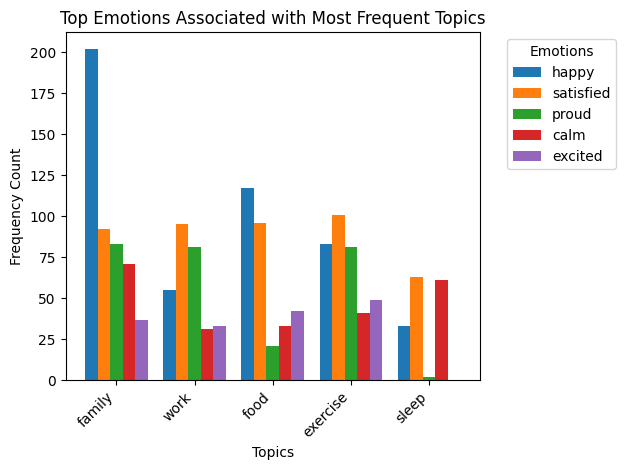

In [5]:

topic_frequencies = df[topic_cols].sum().sort_values(ascending=False)
top_topics = topic_frequencies.head(5).index

emotion_topic_relationship = pd.DataFrame(0, index=emotion_cols, columns=topic_cols)

for topic in topic_cols:
    for emotion in emotion_cols:
        emotion_topic_relationship.loc[emotion, topic] = (
            df[emotion].astype(int) & df[topic].astype(int)
        ).sum()

emotion_sums = emotion_topic_relationship[top_topics].sum(axis=1)
top_emotions = emotion_sums.nlargest(5).index

filtered_data = emotion_topic_relationship.loc[top_emotions, top_topics]
filtered_data_transposed = filtered_data.T

plt.figure(figsize=(14, 7))
filtered_data_transposed.plot(kind="bar", width=0.8)
plt.title("Top Emotions Associated with Most Frequent Topics")
plt.ylabel("Frequency Count")
plt.xlabel("Topics")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


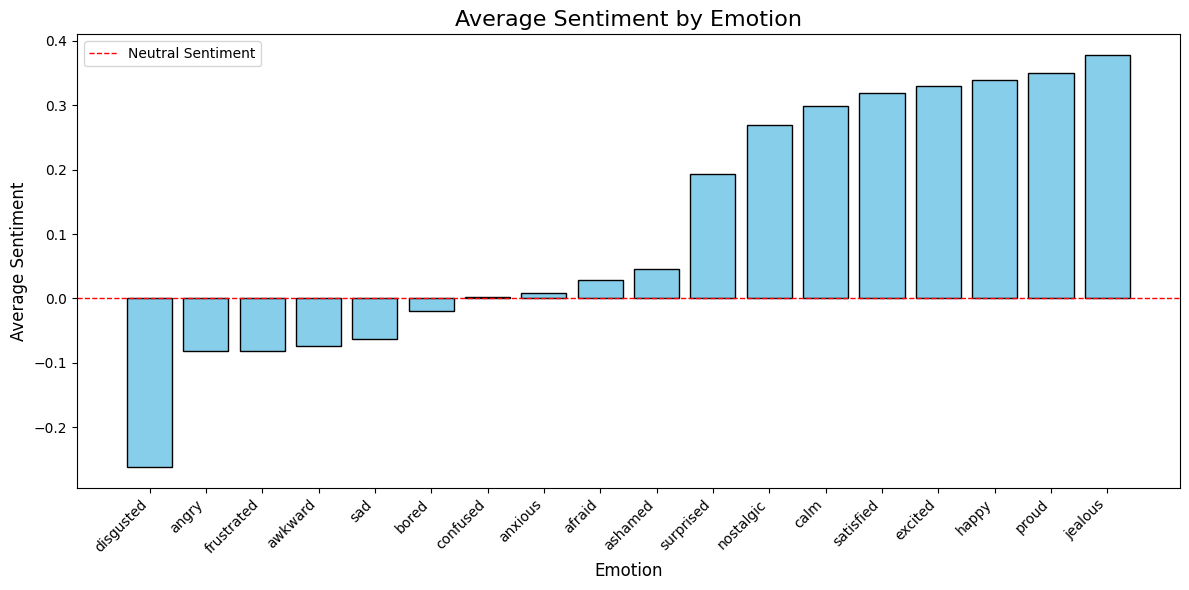

In [9]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt


text_column = 'journal'

df['Sentiment'] = df[text_column].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


average_sentiments = {}
for emotion in emotion_cols:
    emotion_sentiments = df.loc[df[emotion] == True, 'Sentiment']
    average_sentiments[emotion] = emotion_sentiments.mean() if not emotion_sentiments.empty else np.nan

sentiment_analysis_df = pd.DataFrame(list(average_sentiments.items()), columns=['Emotion', 'Average Sentiment'])
sentiment_analysis_df.sort_values(by='Average Sentiment', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(sentiment_analysis_df['Emotion'], sentiment_analysis_df['Average Sentiment'], color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Neutral Sentiment')
plt.title("Average Sentiment by Emotion", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()

plt.show()


In [11]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


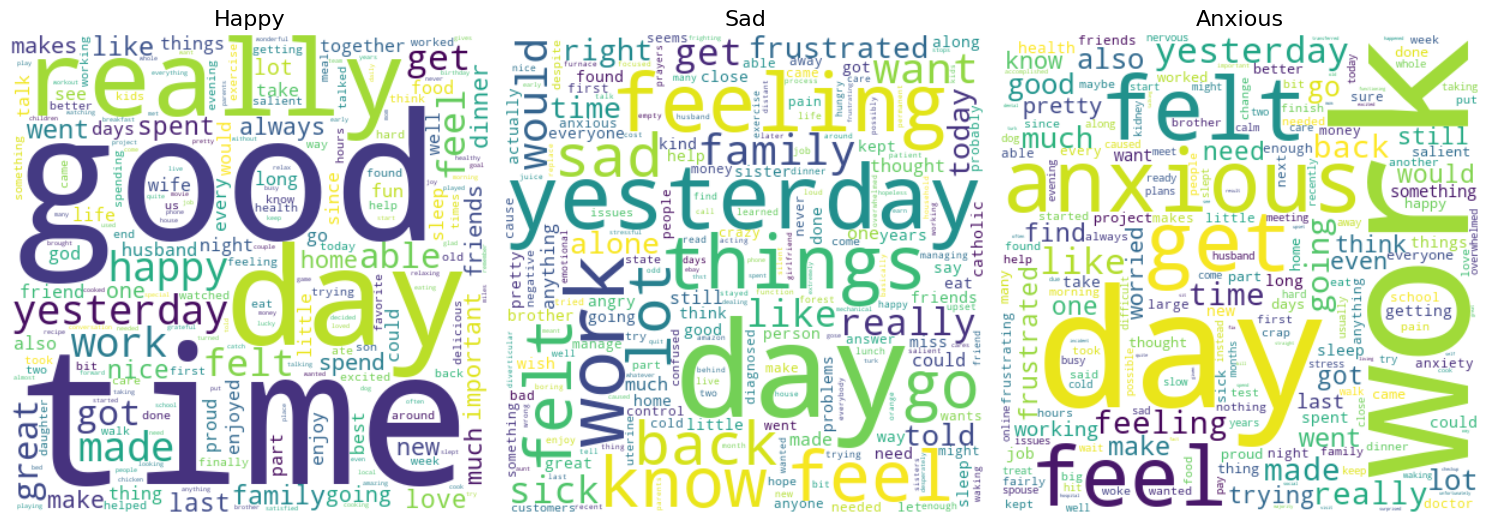

In [14]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
    "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on",
    "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all",
    "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same",
    "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
])


text_column = 'journal'
emotion_data = df[[text_column] + emotion_cols]


def get_filtered_word_frequencies(emotion_col, text_data):
    filtered_texts = text_data[text_data[emotion_col] == True][text_column].dropna()
    word_counts = Counter()
    for text in filtered_texts:
        tokens = text.lower().split()
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        word_counts.update(filtered_tokens)
    return word_counts

selected_emotions = ['happy', 'sad', 'anxious']

emotion_word_counts_filtered = {
    emotion: get_filtered_word_frequencies(emotion, emotion_data) for emotion in selected_emotions
}

plt.figure(figsize=(15, 10))
for idx, (emotion, word_counts) in enumerate(emotion_word_counts_filtered.items(), 1):
    plt.subplot(1, len(selected_emotions), idx)
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(emotion.capitalize(), fontsize=16)

plt.tight_layout()
plt.show()



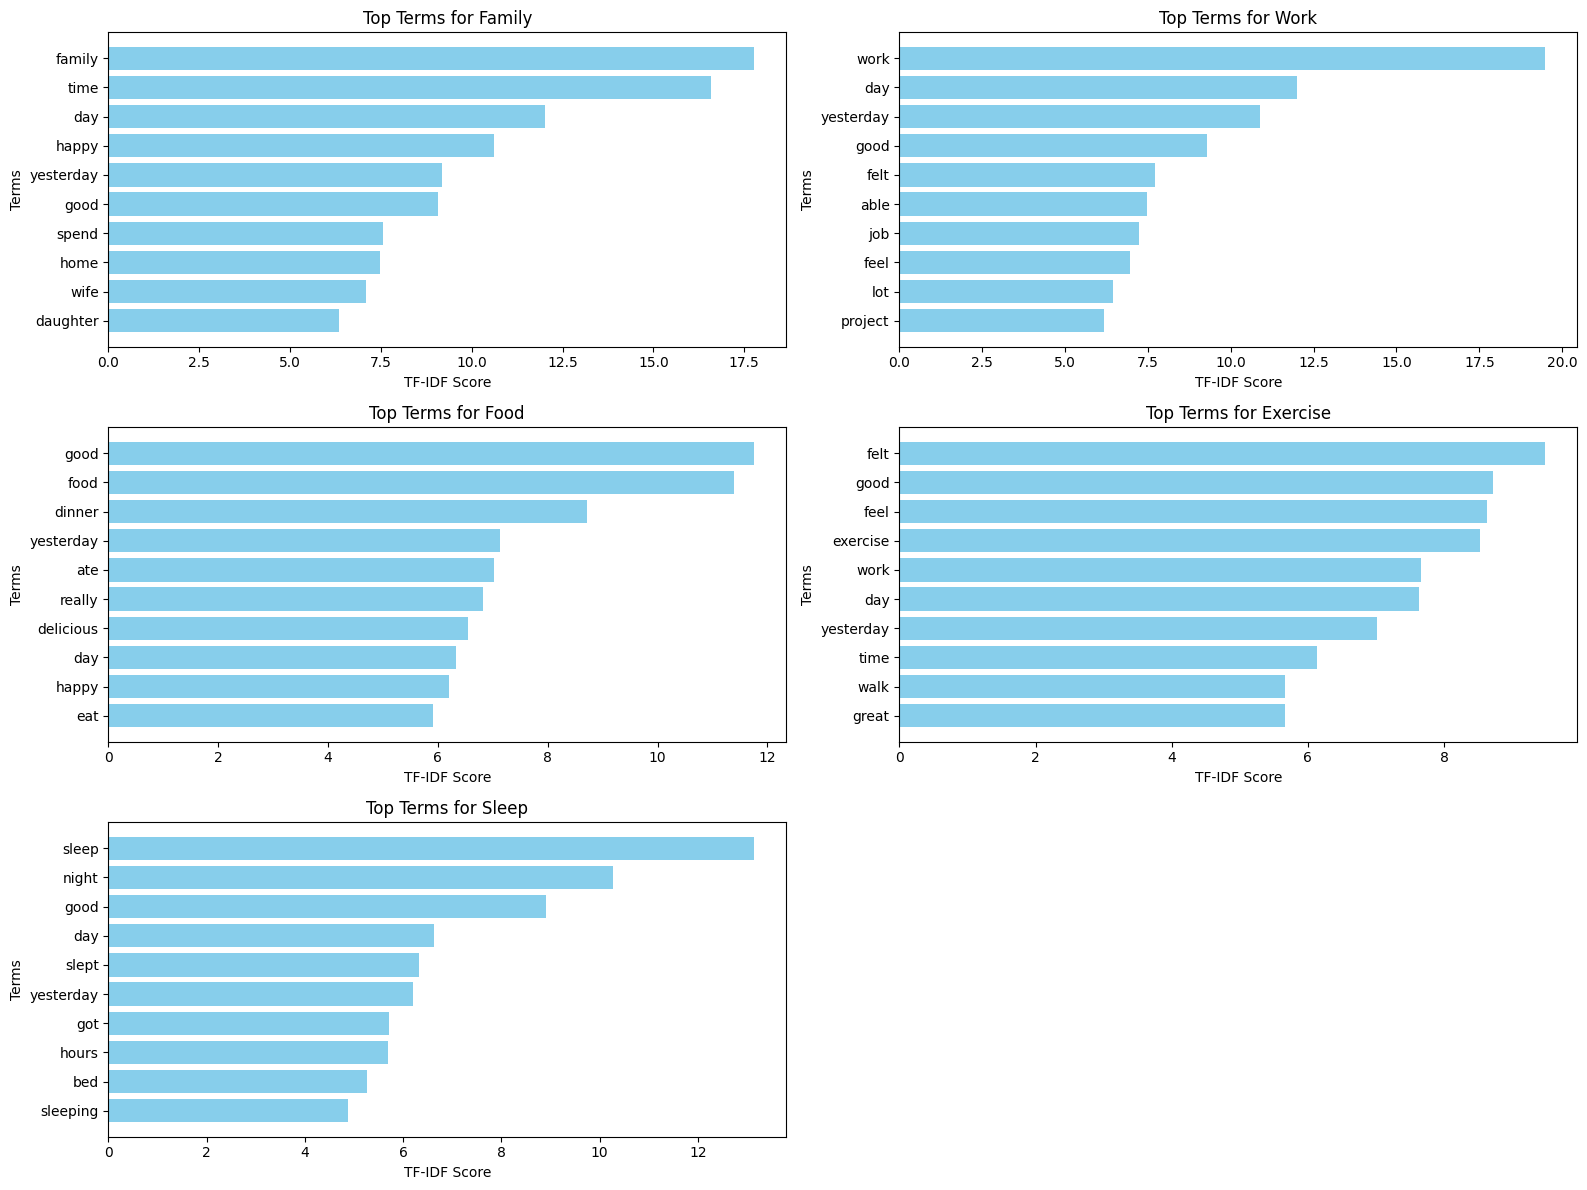

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt

topic_cols = ["exercise", "family", "food", "friends", "god", "health", "love", 
              "recreation", "school", "sleep", "work"]

top_topics = df[topic_cols].sum().sort_values(ascending=False).head(5).index
journal_entries = df['journal']
topic_filtered_entries = {
    topic: journal_entries[df[topic] == True] for topic in top_topics
}

def get_top_terms(entries, top_n=10):
    vectorizer = CountVectorizer(stop_words='english')
    term_matrix = vectorizer.fit_transform(entries.dropna())
    
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(term_matrix)
    
    term_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    
    term_scores_df = pd.DataFrame({'term': terms, 'score': term_scores})
    return term_scores_df.sort_values(by='score', ascending=False).head(top_n)

top_terms_per_topic = {
    topic: get_top_terms(entries) for topic, entries in topic_filtered_entries.items()
}

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (topic, terms) in enumerate(top_terms_per_topic.items()):
    ax = axes[idx]
    ax.barh(terms['term'], terms['score'], color='skyblue')
    ax.set_title(f"Top Terms for {topic.capitalize()}")
    ax.set_xlabel("TF-IDF Score")
    ax.set_ylabel("Terms")
    ax.invert_yaxis()

for ax in axes[len(top_terms_per_topic):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [16]:

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

X = df[topic_cols]      
y = df[emotion_cols]         

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000))
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Classification Report (Emotion-wise):\n")
print(classification_report(y_test, y_pred, target_names=emotion_cols))


Classification Report (Emotion-wise):

              precision    recall  f1-score   support

      afraid       0.00      0.00      0.00         2
       angry       0.00      0.00      0.00         5
     anxious       0.00      0.00      0.00        23
     ashamed       0.00      0.00      0.00         4
     awkward       0.00      0.00      0.00         4
       bored       0.00      0.00      0.00        15
        calm       0.58      0.13      0.21        87
    confused       0.00      0.00      0.00         7
   disgusted       0.00      0.00      0.00         3
     excited       0.00      0.00      0.00        46
  frustrated       0.00      0.00      0.00        28
       happy       0.71      0.65      0.68       153
     jealous       0.00      0.00      0.00         0
   nostalgic       0.00      0.00      0.00         6
       proud       0.00      0.00      0.00        66
         sad       0.00      0.00      0.00         6
   satisfied       0.44      0.12      0.1

/opt/anaconda3/envs/bigdata2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/bigdata2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/bigdata2025/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 